# Machine learning for genetic data

## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications.

Here we will work with GWAS data from _Arabidopsis thaliana_, which is a plant model organism (https://upload.wikimedia.org/wikipedia/commons/6/6f/Arabidopsis_thaliana.jpg).

The genotypes are hence described by **Single Nucleotide Polymorphisms, or SNPs**. Our goal will be to use this data to identify regions of the genome that can be linked with various growth and flowering traits (**phenotypes**).

In [2]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.rc('font', **{'size': 16}) # font size for text on plots

## Data description

* `data/athaliana_small.X.txt` is the design matrix. As many rows as samples, as many columns as SNPs
* the SNPs are given (in order) in `data/athaliana_small.snps.txt`. 
* the samples are given (in order) in `data/athaliana.samples.txt`.

* the transformed phenotypes are given in `data/athaliana.4W.pheno` and `data/athaliana.2W.pheno`. The first column is the sample's ID, and the second the phenotype.

* `data/athaliana.candidates.txt` contains a list of _A. thaliana_ genes known or strongly suspected to be associated with flowering times.

* the feature network is in `data/athaliana_small.W.txt`. It has been saved as 3 arrays, corresponding to the row, col, and data attributes of a [scipy.sparse coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html).

## Loading the data
We will start by working without the feature network, on the 2W phenotype.

In [4]:
# Load the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

9419


In [5]:
# Load the design matrix -- this can take time!
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers

__Q: How many samples are there in the data? How many SNPs are there?__

In [6]:
# Answer:



In [7]:
p = X.shape[1]

#### Load the sample names

In [8]:
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype = int)) # values are integers
print(len(samples))

1307


#### Load the 2W phenotype data

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header = None, # columns have no header
                 delim_whitespace = True) # columns are separated by white space

The 2W phenotype is not available for all samples.

In [11]:
# Create vector of sample IDs
samples_with_phenotype = list(df[0])
print(len(samples_with_phenotype), "samples have a phenotype")

# Create vector of phenotypes
y_2W = np.array(df[1])

152 samples have a phenotype


We need to restrict X to the samples with a 2W phenotype, in correct order

In [12]:
# X_2W[i] = X[samples.index(samples_with_phenotype[i])]
X_2W = X[np.array([samples.index(sample_id) \
                   for sample_id in samples_with_phenotype]), :]

__Q: How many samples do we have now? And how many SNPs? Does this make the task of biomarker detection simpler or harder?__

In [13]:
# Answer:



In [14]:
# You can delete X now if you want, to free space
del X

#### Load the list of candidate genes

In [15]:
with open('data/athaliana.candidates.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

#### Load the snps to gene mapping

In [16]:
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/athaliana.snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

### Split the data in a train and test set

In machine learning, we always split the data into a *train* set, which serves to fit the model, and a *test* set, which serves to measure the model's performance.

__Q: Do you remember why? What happens if we do both the training and testing on the same data?__

**Answer:**



We will set aside a test set, containing 20% of our samples, on which to evaluate the quality of our predictive models.

__Q: What problem occurs if we set a test set that is too large in proportion? What problem occurs when it is set too small?__

**Answer:**



In [17]:
from sklearn import model_selection

In [18]:
X_2W_tr, X_2W_te, y_2W_tr, y_2W_te = \
    model_selection.train_test_split(X_2W, y_2W, test_size = 0.2, random_state = 17)
print(X_2W_tr.shape, X_2W_te.shape)

(121, 9419) (31, 9419)


## Visualize the data

Visualize the phenotype

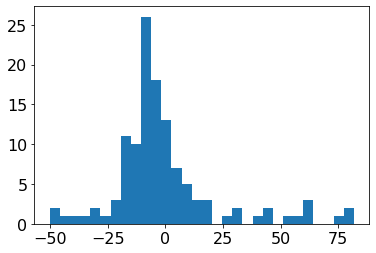

In [19]:
h = plt.hist(y_2W_tr, bins = 30)

Visualize the genotype's correlation structure

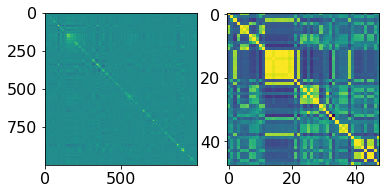

In [20]:
import seaborn as sn
sigma = pd.DataFrame(X_2W_tr).corr()

fig, ax = plt.subplots(1,2)
ax[0].imshow(sigma.iloc[0:1000, 0:1000])
ax[1].imshow(sigma.iloc[72:120, 72:120])
#sn.heatmap(sigma.iloc[72:120, 72:120], cmap = "viridis")
plt.show()

__Q: What observation can you make about the phenotype and genotype?__

## T-test

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [21]:
import statsmodels.api as sm

### T-test on a single SNP
We will perform a linear regression on a single SNP and test whether this SNP has an effect on the phenotype.

In [22]:
est = sm.regression.linear_model.OLS(y_2W_tr, sm.add_constant(X_2W_tr[:, 0])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.038
Date:                Tue, 30 Mar 2021   Prob (F-statistic):              0.310
Time:                        15:50:28   Log-Likelihood:                -552.37
No. Observations:                 121   AIC:                             1109.
Df Residuals:                     119   BIC:                             1114.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8295      2.588     -0.707      0.4

__Q: In the previous table, where is the p-value of the T-test? What can you conclude about the effect of the first SNP on the phenotype?__

Answer:



We can also visualize the linear regression:

[(-0.1, 1.1)]

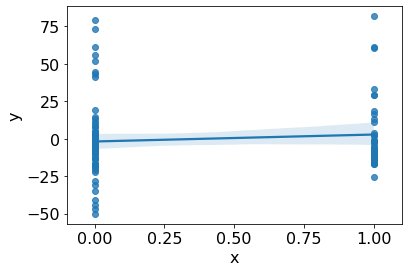

In [23]:
import seaborn as sn
sn.regplot(x = 'x', y = 'y', data = pd.DataFrame({'x': X_2W_tr[:, 0], 'y': y_2W_tr})).set(xlim = (-0.1, 1.1))

### T-test on all SNPs

In [25]:
pvalues = []
for snp_idx in range(p):
    # only look a the column corresponding at that SNP
    X_snp = X_2W_tr[:, snp_idx]
    # run a linear regression (with bias) between the phenotype and this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_tr, X_snp)
    est2 = est.fit()
    # get the p-value from the model 
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0.0, 9419.0)

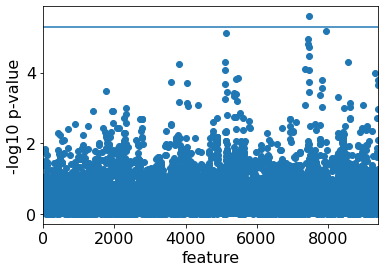

In [26]:
plt.scatter(range(p), # x = SNP position
            -np.log10(pvalues)) # y = -log10 p-value 

# significance threshold according to Bonferroni correction
t = -np.log10(0.05 / p)
plt.plot([0, p], [t, t])

# plot labels
plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

__Q: What do you observe? Are any SNPs significantly associated with the phenotype? 
Use data/athaliana.snps_by_gene.txt and data/athaliana.candidates.txt to check whether this matches a priori information.__

In [2]:
# Answer:



## Linear regression 

In [29]:
from sklearn import linear_model

In [30]:
model_lr = linear_model.LinearRegression(fit_intercept = True)
model_lr.fit(X_2W_tr, y_2W_tr)

LinearRegression()

(0.0, 9419.0)

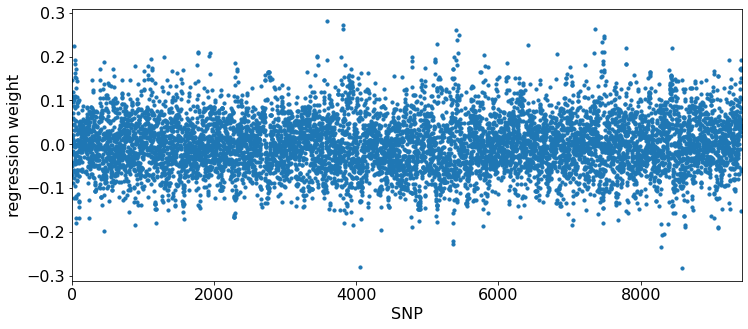

In [31]:
plt.figure(figsize = (12, 5))
plt.scatter(range(p), # x = SNP position
            model_lr.coef_, # y = regression weights
            s = 10)  # point size

plt.xlabel("SNP")
plt.ylabel("regression weight")
plt.xlim([0, p])

__Q: What do you observe? How can you interpret these results? Do any of the SNPs strike you as having a strong influence on the phenotype?__

In [3]:
# Answer: 



### Model predictive power

In this section, we measure the performance of our model on the test dataset.
There are two properties to measure: how well we correct the phenotype and how well we select the causal SNPs.

__Q: In the setting of this practical, only one of those can be measured. Which one, and why? In what setting can we also measure the other property?__

**Answer:**

We will now look at the predictive power of the lasso estimated model.

__Q: What is the definition of the variance explained? You may use the [scikit learn documentation](https://sklearn.org/modules/classes.html#sklearn-metrics-metrics). What values can this metric take? and to what cases do the extreme values correspond to?__

**Answer:**

In [37]:
from sklearn import metrics

In [38]:
y_2W_lr_pred = model_lr.predict(X_2W_te)

print("Percentage of variance explained (using all SNPs): %.2f" % \
    metrics.explained_variance_score(y_2W_te, y_2W_lr_pred))

Percentage of variance explained (using all SNPs): 0.39


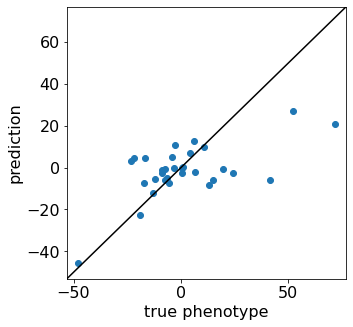

In [39]:
plt.figure(figsize = (5, 5))
plt.scatter(y_2W_te, y_2W_lr_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.ylim([np.min(y_2W_te) - 5, np.max(y_2W_te) + 5])
plt.axline(xy1 = [0, 0], slope = 1, c = "black")

## Lasso

Define lasso model

In [40]:
lasso = linear_model.Lasso(fit_intercept = True, max_iter = 6000)

Define cross-validation grid search and learn lasso with cross-validation.

In [41]:
alphas = np.logspace(-4., 1., num = 20)
model_l1 = model_selection.GridSearchCV(lasso, param_grid = {'alpha': alphas}, 
                                        scoring = 'explained_variance')
model_l1.fit(X_2W_tr, y_2W_tr)

GridSearchCV(estimator=Lasso(max_iter=6000),
             param_grid={'alpha': array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])},
             scoring='explained_variance')

(0.0, 9419.0)

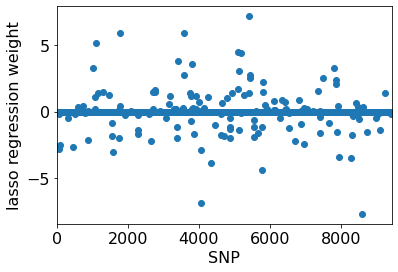

In [42]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNP")
plt.ylabel("lasso regression weight")
plt.xlim([0, p])

__Q: How can you interpret these results? How many SNPs contribute to explaining the phenotype?__

In [43]:
print("%d SNPs selected" % \
    np.nonzero(model_l1.best_estimator_.coef_)[0].shape)

167 SNPs selected


__Q: How many of theses SNPS belong to the list of *candidate SNPs*?__

In [9]:
#candidate_genes_hit = set([])
#num_snps_in_candidate_genes = 0
#for snp_idx in np.nonzero(model_l1.best_estimator_.coef_)[0]:
#    for gene_id in genes_by_snp[snp_names[snp_idx]]:
#        if gene_id in candidate_genes:
#            # this line is missing
#            # this line is missing



#print("Of which %d are in %d candidate genes" % (num_snps_in_candidate_genes, len(candidate_genes_hit)))

### Predictive power 

In [46]:
y_2W_l1_pred = model_l1.best_estimator_.predict(X_2W_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_2W_te, y_2W_l1_pred)))

Percentage of variance explained (using 167 SNPs): 0.37


__Q: How does the lasso compare with the OLS (linear regression) in terms of variance explained? Compared to the linear regression, what is the advantage of the lasso model for generating biological hypotheses?__

**Answer:**

Comparing true and predicted phenotypes

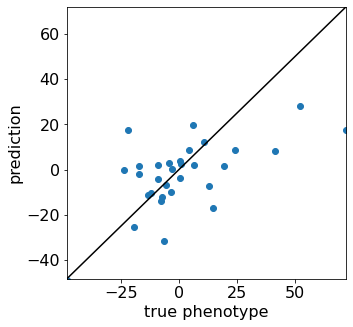

In [47]:
plt.figure(figsize = (5, 5))
plt.scatter(y_2W_te, y_2W_l1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.xlim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.ylim([np.min(y_2W_te) - 0.05, np.max(y_2W_te) + 0.05])
plt.axline(xy1 = [0, 0], slope = 1, c = "black")